# Ice - Games Sales Analysis

## Introduction

A set of data has been provided to be analysed from an online game platform, Ice. The goal of this analysis is to determine which games will likely to succeed in various markets across the globe and which advertising campaigns the marketing team should prioritise.

The analysis will be done in the following stages:
1. Overview of the general information of the dataset to provide the big picture of the data of which we are about to analyse.
2. Data preprocessing which shall include finding and replacing missing values and errors, removing duplicates, converting data types and adding relevant new column.
3. Data categorisation and transformation for exploratory data analysis to view the correlation between multiple parameters and game sales.
4. Testing hypotheses and achieving overall conclusions.

## General Information

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy import stats as st
from scipy.stats import spearmanr
import matplotlib.gridspec as grid_spec
import warnings
warnings.simplefilter("ignore")

In [2]:
# read the csv file
try:
    game_data = pd.read_csv('games.csv')
except:
    game_data = pd.read_csv('/datasets/games.csv')

In [3]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
game_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
game_data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [6]:
#check the percentage of missing values in the dataset
report = game_data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / game_data.shape[0]).round(2) * 100
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
Critic_Score,8578,51.0
Rating,6766,40.0
User_Score,6701,40.0
Year_of_Release,269,2.0
Name,2,0.0
Genre,2,0.0
Platform,0,0.0
NA_sales,0,0.0
EU_sales,0,0.0
JP_sales,0,0.0


### General Information Summary

1. The dataset has 10 columns, consisting of quantitative and categorical data.
2. There are some missing values and errors in several columns, some of them have pretty big percentage that may skew the data if dropped or filled randomly.
3. Some of the data types are incorrect, this may cause problems upon further analysis.

By initially looking at the dataset and general information about the data, the structure of the data is starting to show. We can now proceed to process the data for the missing values, data categorisation and outliers identification and removal to prepare us for further analysis.

## Data Preprocessing

In [7]:
# replace column names to lowercase
game_data.columns = game_data.columns.str.lower()
game_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Name

In [8]:
game_data.loc[game_data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


These games look quite old and there is not obvious pattern as to why the name is missing, it could be a mistake upon data entry. Since there are only 2 of them in the entire dataset, we can drop them without skewing the dataset.

In [9]:
# drop the missing values
game_data = game_data.dropna(subset=['name'], axis=0)

In [10]:
game_data = game_data.reset_index()

In [11]:
game_data['name'].isna().sum()

0

### Year of Release

There are 2% of missing values in the year of release, let's take a look at them first and find out the possible reason why are they missing.

In [12]:
game_data[game_data['year_of_release'].isna()].head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Some of the games have the year in their name, such as FIFA Soccer 2004, we can assume it is released in 2004 so we can fill them into the missing year of release values.

In [13]:
# create a column that pulls year in name to try and fill in the missing values in year of release
result = []
numbers = []

for i in range(len(game_data)):
    temp = re.findall(r'\d+', str(game_data.name[i]))
    res = list(map(int, temp))
    result.append(res)
    
game_data['result'] = result

i=0

for i in range(len(game_data)):
    game_data['result'][i] = str(game_data['result'][i])
    if game_data['result'][i] == '[]':
        game_data['result'][i] = '[0]'
game_data['result'] = game_data['result'].str.strip('[')
game_data['result'] = game_data['result'].str.strip(']')

for i in range(len(game_data)):
    if len(game_data['result'][i].split()) > 1:
        game_data['result'][i] = 0
game_data['result'] = game_data['result'].astype('int')

for x in range(len(game_data)):
    if game_data.result[x] < 1950 or game_data.result[x] > 2021:
        game_data.result[x] = 0
        
print(game_data['result'].value_counts())

0       15940
2002       74
2004       61
2000       61
2010       59
2005       51
2003       50
2009       46
2001       44
2011       43
2008       43
2014       39
2015       35
2016       34
2012       32
2006       31
2013       28
2007       22
2017       16
1996        2
1999        2
Name: result, dtype: int64


In [14]:
# fill in the value in result to year of release
game_data['year_of_release'].fillna(game_data['result'], inplace=True)

In [15]:
game_data.loc[game_data['year_of_release'] == 0].head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,result
456,456,LEGO Batman: The Videogame,Wii,0.0,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+,0
609,609,Space Invaders,2600,0.0,Shooter,2.36,0.14,0.0,0.03,NaN,NaN,NaN,0
627,627,Rock Band,X360,0.0,Misc,1.93,0.33,0.0,0.21,92.0,8.2,T,0
657,657,Frogger's Adventures: Temple of the Frog,GBA,0.0,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E,0
677,678,LEGO Indiana Jones: The Original Adventures,Wii,0.0,Action,1.51,0.61,0.0,0.21,78.0,6.6,E10+,0


There are still plenty of missing values in year of release (transformed into 0), so we can try to fill them in with other parameters.

In [16]:
game_data.loc[game_data['year_of_release'] == 0, 'year_of_release'] = np.nan

In [17]:
game_data['year_of_release'] = game_data.groupby(['platform','genre'])['year_of_release'].apply(lambda x: x.fillna(x.mean()))

In [18]:
game_data['year_of_release'] = game_data['year_of_release'].astype(int)

In [19]:
game_data['year_of_release'].isna().sum()

0

### Total Sales

In [20]:
# add total sales column
game_data['total_sales'] = game_data['na_sales'] + game_data['eu_sales'] + game_data['jp_sales'] + game_data['other_sales']

### Scores

In [21]:
# change TBD to NaN
game_data.loc[game_data['user_score'] == 'tbd', 'user_score'] = np.nan

In [22]:
game_data.loc[game_data['user_score'].isna()].head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,result,total_sales
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,0,40.24
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,0,31.38
5,5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,0,30.26
9,9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,0,28.31
10,10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,0,24.67


By looking at those missing values in user_score, we can see that most of the time the critic_score and rating columns are also missing. It looks like they're mostly from old platforms.

We can check if user_score has enough correlation with critic_score, if the result is high enough, we can fill in the missing values of user_score with median value of the same games grouped by their critic_score and vice versa. 

In [23]:
# convert user score from object to float
game_data['user_score'] = game_data['user_score'].astype(float)

In [24]:
# check correlation between user_score and critic_score
game_data['user_score'].corr(game_data['critic_score'])

0.5808778320767239

The result is high enough, around 0.58, therefore we can continue with the idea to fill in the missing values in user score with values in critic score and vice versa.

In [25]:
# fill in missing values in user and critic score
game_data['user_score'] = game_data.groupby('critic_score')['user_score'].apply(lambda x: x.fillna(x.median()))
game_data['critic_score'] = game_data.groupby('user_score')['critic_score'].apply(lambda x: x.fillna(x.median()))

In [26]:
print(game_data['user_score'].isna().sum())
print(game_data['critic_score'].isna().sum())

8576
8576


There are still a lot of missing values in user and critic score so we will use additional parameter to fill them in.

In [27]:
game_data['user_score'] = game_data.groupby(['total_sales', 'genre'])['user_score'].apply(lambda x: x.fillna(x.median()))
game_data['critic_score'] = game_data.groupby(['total_sales', 'genre'])['critic_score'].apply(lambda x: x.fillna(x.median()))

In [28]:
# check how much missing values left in the two columns
print(game_data['user_score'].isna().sum() / len(game_data) * 100)
print(game_data['critic_score'].isna().sum() / len(game_data) * 100)

5.887632381978101
5.887632381978101


### Rating

In [29]:
game_data['rating'] = game_data.groupby('genre')['rating'].apply(lambda x: x.fillna(x.mode()[0]))

In [30]:
game_data['rating'].isna().sum()

0

In [31]:
report = game_data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / game_data.shape[0]).round(2) * 100
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
critic_score,984,6.0
user_score,984,6.0
index,0,0.0
name,0,0.0
platform,0,0.0
year_of_release,0,0.0
genre,0,0.0
na_sales,0,0.0
eu_sales,0,0.0
jp_sales,0,0.0


Now only around 6% of the total data from user and critic score are still missing, we can leave them be for now until it's necessary to do drop or fill them later.

### Checking Duplicates & Data Types

In [32]:
# check for duplicates
print('This dataset has {} duplicates.'.format(game_data.duplicated().sum()))

This dataset has 0 duplicates.


In [33]:
# drop the result column
game_data.drop(['result'], axis = 1, inplace=True)

In [34]:
game_data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,E,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,T,31.38


### Conclusion

In this data preprocessing section:
- We have checked the missing values, some columns have a tiny bit of them, such as name and genre, this could be caused by human mistake during data entry. We dropped these rows as it would not affect the dataset too much.
- Year of release have higher amount of missing values but still not so significant, we filled them in with the year that appears in the name of the game (e.g. FIFA 2015, LMA Manager 2007) and fill the rest with median of platform and genre. The missing values in year of release are totally random and could be an error during data retrieval.
- We added total sales column which is the sum of the sales in each region.
- There are games with three missing values in the following columns: user score, critic score and rating. There is no obvious patterns to these games. Some of the games are from older platforms that people don't really use anymore, other than that, these could be an error during data retrieval. 
- The scores have higher percentage of missing values and we tested if they have high correlation to one another, then try to fill them in with the median of each other's values, as well as the total sales and genre.
- For rating, we used the genre as normally each genre are presented for different audience age group.
- We changed the data types for user score and year of release.
- We found that this dataset does not have any duplicates.

Now the dataset is ready for further analysis.

## Exploratory Data Analysis

In this section, we will analyse the games' sales based on their year of release, platform, genre, reviews and ratings. 

### Games Released Each Year

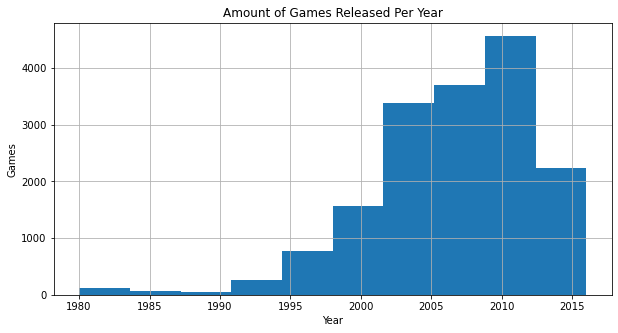

In [35]:
game_data['year_of_release'].hist(bins = 10, figsize=(10,5))
plt.title('Amount of Games Released Per Year')
plt.xlabel('Year')
plt.ylabel('Games');

Based on the histogram, the amount of games released started to increase exponentially in the 1990s, it was a decade of marked innovation in video gaming, introduction of home consoles and Nintendo's Game Boy was released that got everyone into video games. We can also see that most games are released towards the end of 2000s until around 2012.

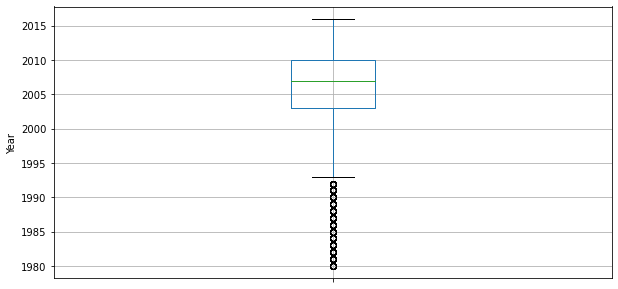

In [36]:
game_data['year_of_release'].plot(kind='box', figsize=(10,5), grid=True)
plt.xticks([1], [])
plt.ylabel('Year');

Looking at the boxplot, the interquartile range is between 2003-2010, with median around 2007. This might coincide with the boom of significant technological advancement with smartphones and social media. Ironically, those two things are also the things that may cause a decline in video games release afterwards, as video gaming became more of a niche product.

### Total Sales By Platform

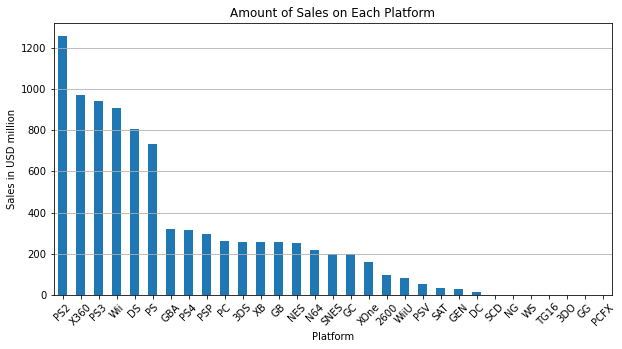

In [37]:
game_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Amount of Sales on Each Platform')
plt.xlabel('Platform')
plt.ylabel('Sales in USD million')
plt.grid(axis='y')
plt.xticks(rotation=45);

In the bar chart, it's obvious that 6 platforms dominate the sales in significant manner: PS2, X360, PS3, Wii, DS, and PS. There are 7 platforms which sales are close to zero: SCD, NG, WS, TG16, 3DO, GG and PCFX. These platforms have pretty short lifespans and discontinued due to not selling well at the market, therefore it makes sense that the games released there are also minuscule. At this section of the analysis, we will focus on the highest selling platforms.

In [38]:
def plot_distribution(df, x, y, column ='', value='', func=np.sum):
    if column != '' and value != '':
        filter_df = df[df[column] == value]
        plot_df = filter_df.pivot_table(index=x, values=y, aggfunc=func)
        values_to_plot = plot_df[y].values
    else:
        plot_df = df.pivot_table(index=x, values=y, aggfunc=func)
        values_to_plot = plot_df[y].values
        
    xlabel = x.replace('_', ' ').title()
    ylabel = str(y.replace('_', ' ').title())
    title = str(value) + " - " + ylabel + " Each Year"
    
    ax = plot_df.plot(kind='bar', figsize=(10,5), title=title, legend=False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(axis='y')

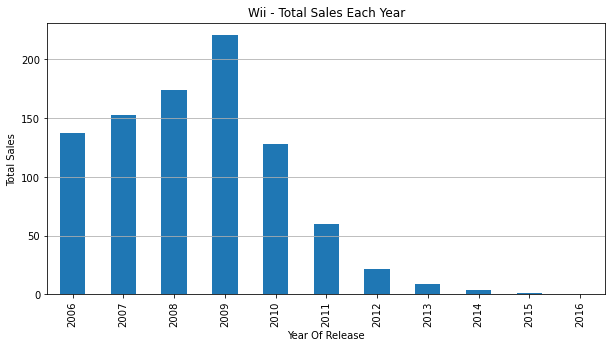

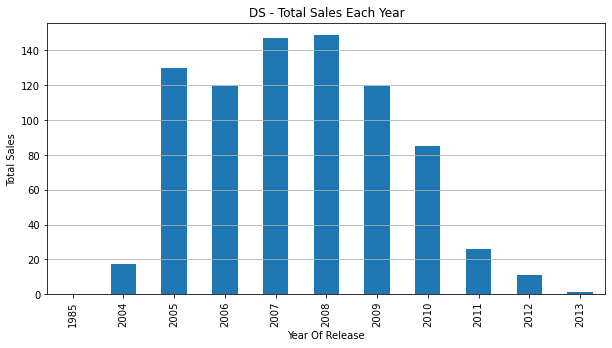

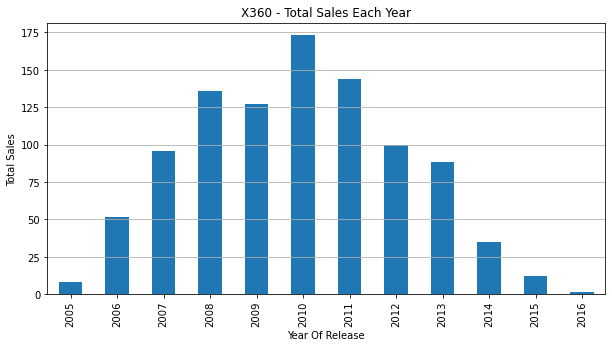

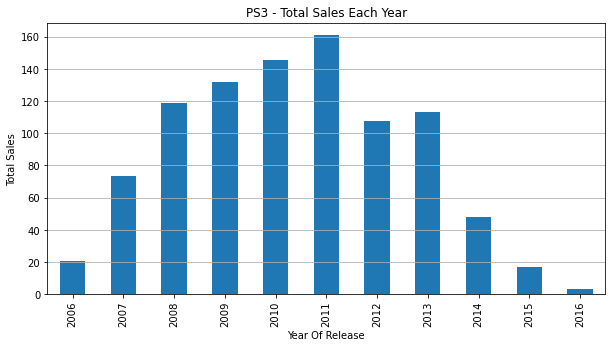

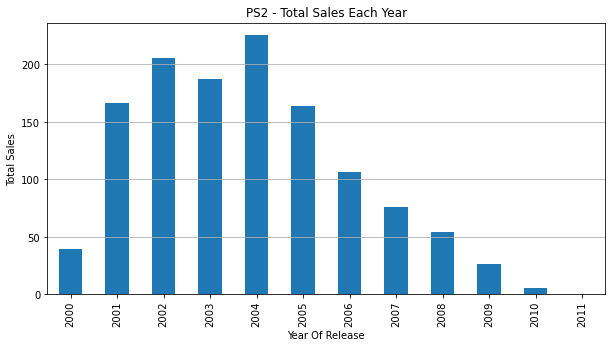

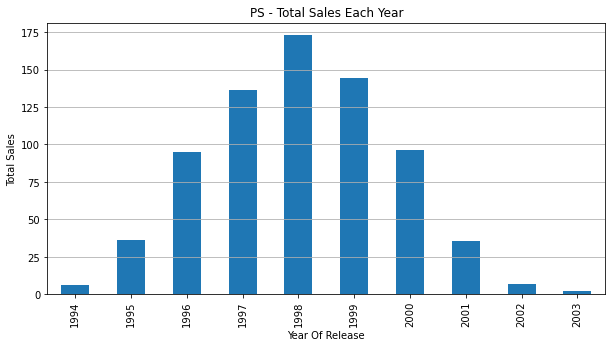

In [39]:
popular_platform = game_data[game_data['platform'].isin(['PS2','X360','PS3','Wii','DS','PS'])]

for platform in popular_platform['platform'].unique():
    plot_distribution(popular_platform, 'year_of_release', 'total_sales', 'platform', platform)

- Playstation platforms always perform really well for a 5-6 years until it phases out and replaced by their newer counterpart.
- Nintendo platforms, like DS and Wii, generally doing really well towards the end of the 2000s. There are a few years where they both co-exist and selling equally high.
- XBOX was the hit console in 2010, but then it phased out fast and have really low sale by 2015.
- A typical lifespan of each platform is about 10-11 year. This typical lifespan is slightly decreasing with time.

### Slicing Dataset By Year

As the aim of this analysis is to build prognosis for 2017, it makes sense to analyse the platforms that are still being widely used at the time of data retrieval (2016). For that, we will need to check which platform still has sales in 2016.

In [40]:
new_sales = game_data.query('(year_of_release == 2016) & (total_sales > 1)')
new_sales['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU'], dtype=object)

We found that PS4, 3DS, XOne, WiiU makes more than USD 1 million of sales in 2016. We can inspect which year these platforms are released and decide from which year the data is still relevant.

In [41]:
new_platform = game_data[game_data['platform'].isin(new_sales['platform'])]

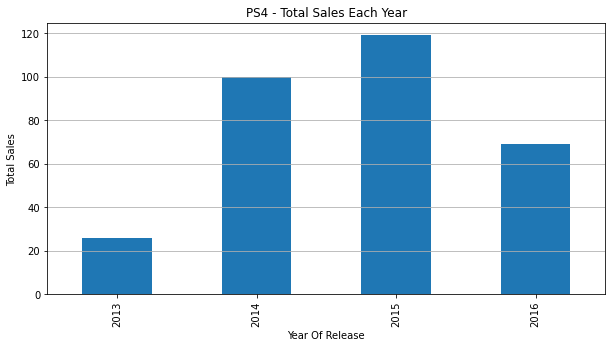

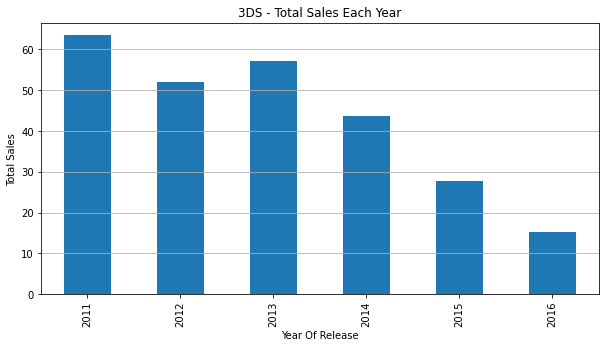

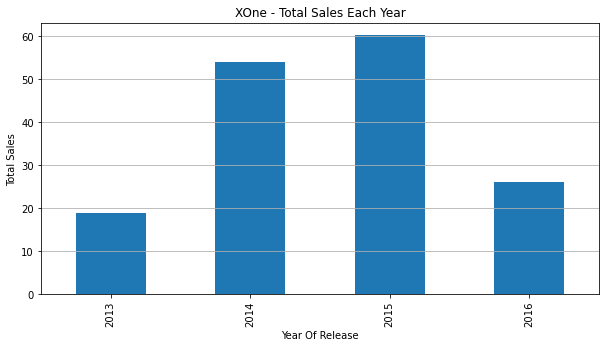

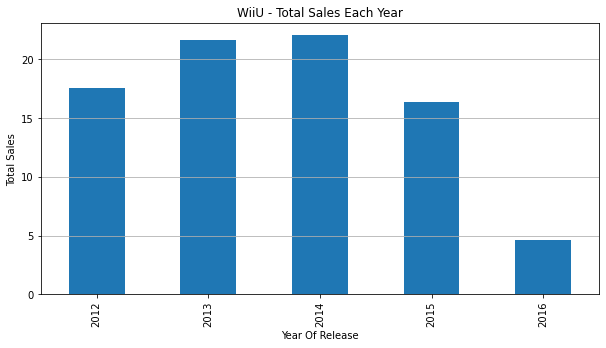

In [42]:
for platform in new_platform['platform'].unique():
    plot_distribution(new_platform, 'year_of_release', 'total_sales', 'platform', platform)

These platforms are all released between 2011-2013, so let's take the median and we will slice the dataset and only analyse games released from 2012 onwards.

In [43]:
data_filtered = game_data.query('year_of_release >= 2012')

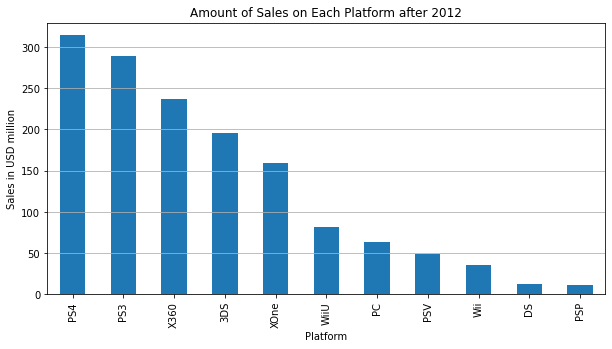

In [44]:
data_filtered.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Amount of Sales on Each Platform after 2012')
plt.xlabel('Platform')
plt.ylabel('Sales in USD million')
plt.grid(axis='y');

We can see that after filtering the dataset, PS4 is leading the sales at more than 300 million, it's amazing that this platform achieved that in just 4 years. PS3 and X360 are following behind it as they are released in 2007 and have begun to phase out and replaced by the newer platforms.

### Global Sales by Platform

In [45]:
platform_average_sales = data_filtered.pivot_table(index='platform',
                                                   values='total_sales',
                                                   aggfunc=['count', 'mean']).reset_index()

platform_average_sales.columns = ['platform', 'total_games', 'avg_sales']

platform_average_sales.sort_values('avg_sales', ascending=False)

,platform,total_games,avg_sales
9,X360,292,0.810068
4,PS4,392,0.801378
7,Wii,54,0.655000
10,XOne,247,0.645020
3,PS3,493,0.585781
8,WiiU,147,0.559116
0,3DS,402,0.486667
1,DS,31,0.404839
2,PC,251,0.250996
6,PSV,412,0.120000


The leading sales is coming from PS4 with 392 games and X360 with 292 games. Wii is still relatively new at the time of data retrieval with only 54 games but already making a huge sales.

In [46]:
data_filtered.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,402.0,0.486667,1.377399,0.01,0.0400,0.11,0.3100,14.60
DS,31.0,0.404839,1.439245,0.01,0.0200,0.05,0.1850,8.06
PC,251.0,0.250996,0.493690,0.01,0.0300,0.08,0.2400,5.14
PS3,493.0,0.585781,1.462855,0.01,0.0500,0.20,0.6100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.20,0.7300,14.63
PSP,173.0,0.064682,0.071296,0.01,0.0200,0.03,0.0900,0.36
PSV,412.0,0.120000,0.202882,0.01,0.0200,0.05,0.1200,1.96
Wii,54.0,0.655000,1.165447,0.01,0.0625,0.18,0.6875,6.76
WiiU,147.0,0.559116,1.058836,0.01,0.0800,0.22,0.5250,7.09


We have a lot of platforms to work with, but for ease of analysis, we will focus on the platforms making more than USD 100 million after 2012.

In [47]:
sales = data_filtered.groupby('platform').agg({'total_sales':'sum'}).reset_index()
sales[sales['total_sales'] >= 100]

,platform,total_sales
0,3DS,195.64
3,PS3,288.79
4,PS4,314.14
9,X360,236.54
10,XOne,159.32


In [48]:
platform_include = ['PS4', 'X360', 'PS3', 'XOne', '3DS']
top_platforms = data_filtered.query('platform == @platform_include')

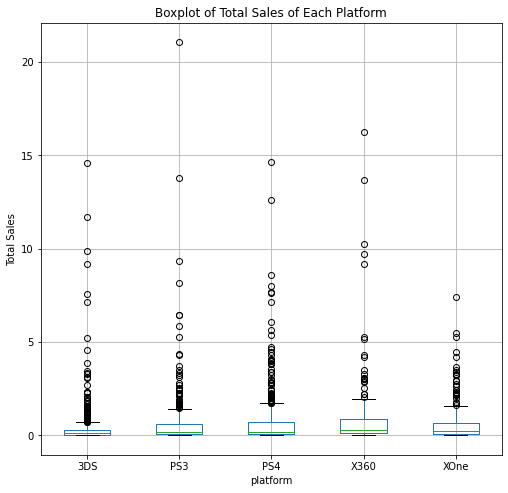

In [49]:
top_platforms.boxplot('total_sales', by='platform', figsize=(8,8), grid=True)
plt.title('Boxplot of Total Sales of Each Platform')
plt.suptitle('')
plt.ylabel('Total Sales');

The boxplots look similar across all 5 platforms, there are no significant differences in sales, although PS3 has some outliers up to more than 20 million USD. The distributions are positively skewed, which is confirmed by the description table above, where mean values are much higher than median.

### Reviews Impact on Sales

On this section, we will look at whether or not reviews from critic or user impact the game's sales. PS4 and X360 would be good platform candidates because they have really high average sales compared to other platforms, but PS4 has more games than X360. Therefore we will use PS4 as an example for this analysis. 

In [50]:
# slice the dataset for only X360
ps4 = data_filtered.query('platform == "PS4"')

# check whether the missing values is high
ps4.isnull().sum() / len(ps4) * 100

index              0.000000
name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       2.806122
user_score         2.806122
rating             0.000000
total_sales        0.000000
dtype: float64

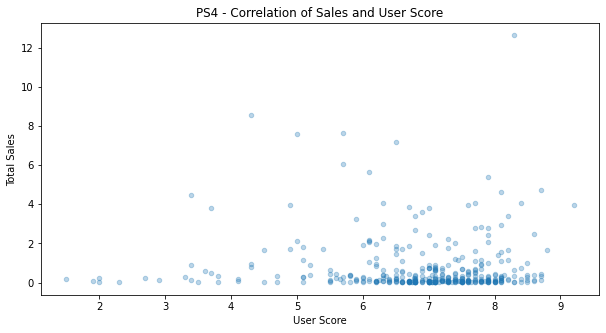

In [51]:
ps4.plot(kind='scatter', y='total_sales', x='user_score', alpha=0.3, figsize=(10, 5))
plt.title('PS4 - Correlation of Sales and User Score')
plt.xlabel('User Score')
plt.ylabel('Total Sales');

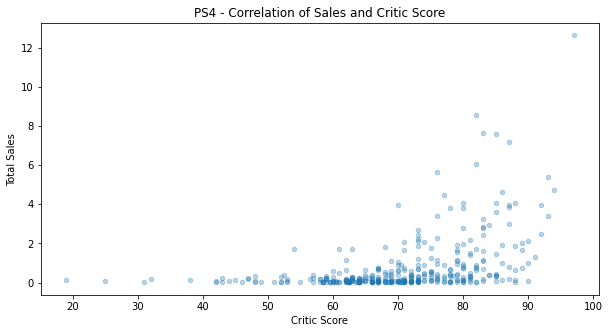

In [52]:
ps4.plot(kind='scatter', y='total_sales', x='critic_score', alpha=0.3, figsize=(10, 5))
plt.title('PS4 - Correlation of Sales and Critic Score')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales');

In [53]:
print('Pearson correlation coefficient between sales and user score is {:.2%}'.format(ps4['total_sales'].corr(ps4['user_score'])))
print('Pearson correlation coefficient between sales and critic score is {:.2%}'.format(ps4['total_sales'].corr(ps4['critic_score'])))

Pearson correlation coefficient between sales and user score is -4.83%
Pearson correlation coefficient between sales and critic score is 44.58%


Based on the scatterplots and Pearson coefficient results above, we can conclude that for PS4 games:
- the user score is slightly inversely correlated to the games' sales.
- the critic score impact on the games' sales is quite high.

### Games Sold in Different Platforms

Now we can take the leading games from PS4 and see how they perform in different platforms.  

In [54]:
ps4.groupby('name')['total_sales'].sum().sort_values(ascending=False).head()

name
Call of Duty: Black Ops 3         14.63
Grand Theft Auto V                12.62
FIFA 16                            8.58
Star Wars Battlefront (2015)       7.98
Call of Duty: Advanced Warfare     7.66
Name: total_sales, dtype: float64

Call of Duty: Black Ops 3 is the best selling game in PS4, but it's quite new (it was released in 2015). Let's see if this game performs well in another high-selling platforms, like PS3 and X360.

In [55]:
(data_filtered
     .query('platform == "PS3"')
     .groupby('name')['total_sales']
     .sum()
     .sort_values(ascending=False).head()
)

name
Grand Theft Auto V            21.05
Call of Duty: Black Ops II    13.79
Call of Duty: Ghosts           9.36
FIFA Soccer 13                 8.17
FIFA 14                        6.46
Name: total_sales, dtype: float64

In [56]:
(data_filtered
     .query('platform == "X360"')
     .groupby('name')['total_sales']
     .sum()
     .sort_values(ascending=False).head()
)

name
Grand Theft Auto V            16.27
Call of Duty: Black Ops II    13.68
Call of Duty: Ghosts          10.24
Halo 4                         9.71
Minecraft                      9.18
Name: total_sales, dtype: float64

Call of Duty: Black Ops 3 doesn't appear in the older platforms, so we use the second highest selling game in PS4, Grand Theft Auto V.

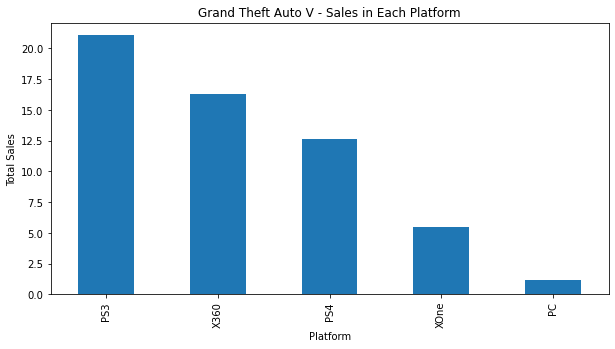

In [57]:
gta = data_filtered.query('name == "Grand Theft Auto V"').groupby('platform')['total_sales'].sum().sort_values(ascending=False)

gta.plot(kind='bar', figsize=(10, 5))
plt.title('Grand Theft Auto V - Sales in Each Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales');

GTA V made high sales in PS3 and X360, above 15 million USD. But then again, these platforms are older than PS4 and XOne. It looks like PS4 and XOne are catching up with the older platforms in terms of sales of this game. Therefore it makes sense to conclude that there is not much difference in sales across the platforms, only the age of the platform itself that seems to affect a certain game's sale.

### Distribution of Games' Genre

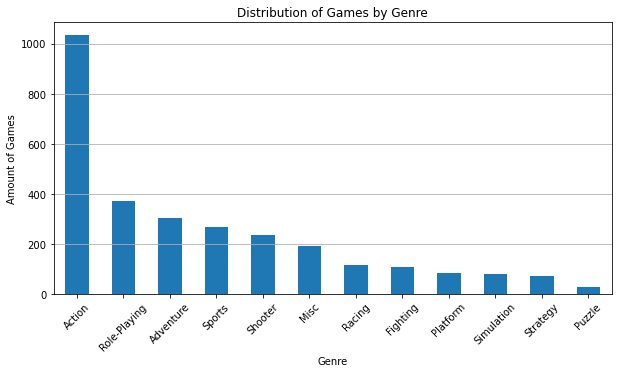

In [58]:
(data_filtered
     .groupby('genre')['genre']
     .count()
     .sort_values(ascending=False)
     .plot(kind='bar', figsize=(10, 5))
)

plt.title('Distribution of Games by Genre')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.ylabel('Amount of Games')
plt.grid(axis='y');

Action games is the most popular genre by significant difference. We can inspect now whether they are also the most profitable.

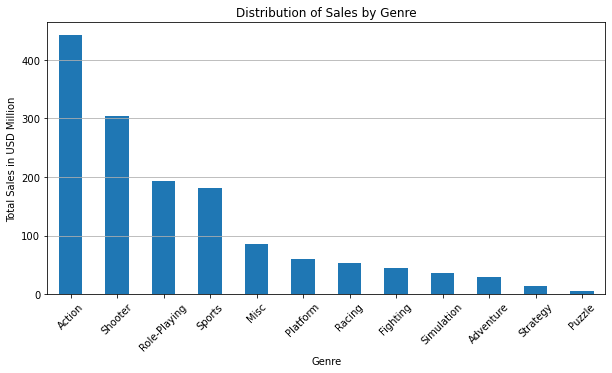

In [59]:
(data_filtered
     .groupby('genre')['total_sales']
     .sum()
     .sort_values(ascending=False)
     .plot(kind='bar', figsize=(10, 5))
)

plt.title('Distribution of Sales by Genre')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.ylabel('Total Sales in USD Million')
plt.grid(axis='y');

As predicted, action is also the most profitable genre, followed by shooter -  with slight difference, despite not being very popular, role-playing and sports. It seems like most people prefer the "active" games like action and shooting, rather than "calm" games like strategy or puzzle. From psychological perspective, it may be that people use aggressive video games as healthy coping mechanism rather than actually committing violence in real life.

## Users Profile for Each Region

### Platforms

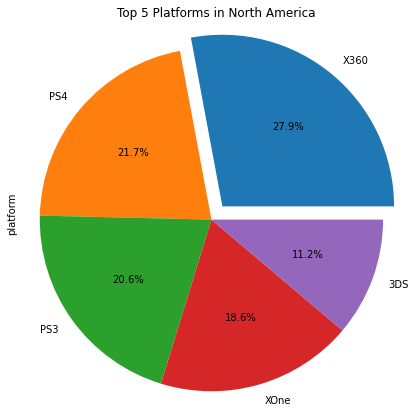

In [60]:
(data_filtered
           .groupby('platform')['na_sales']
           .sum()
           .sort_values(ascending=False)
           .head()
           .plot(kind='pie', figsize=(7, 7), autopct='%1.1f%%', explode = (0.1, 0, 0, 0, 0))
)

plt.axis('equal')
plt.title("Top 5 Platforms in North America")
plt.ylabel('platform');

Users in North America mostly use X360, although not very significant difference. Their preferences are followed by PS4, PS3, XOne and 3DS. So the dominant consoles are developed by Sony and Microsoft.

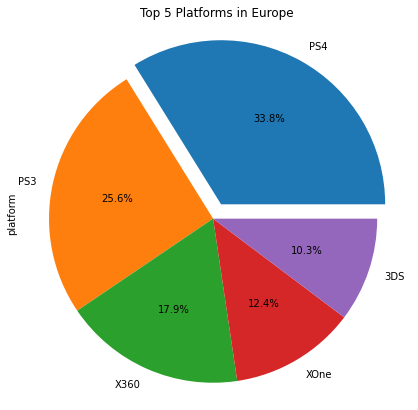

In [61]:
(data_filtered
           .groupby('platform')['eu_sales']
           .sum()
           .sort_values(ascending=False)
           .head()
           .plot(kind='pie', figsize=(7, 7), autopct='%1.1f%%', explode = (0.1, 0, 0, 0, 0))
)

plt.axis('equal')
plt.title("Top 5 Platforms in Europe")
plt.ylabel('platform');

More than a third of users in Europe mostly use PS4. Their preferences are similar to those in North America, but in different orders (followed by PS3, X360, XOne and 3DS). Again the dominant consoles are developed by Sony and Microsoft.

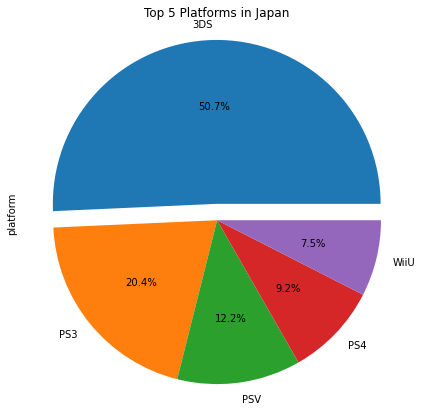

In [62]:
(data_filtered
           .groupby('platform')['jp_sales']
           .sum()
           .sort_values(ascending=False)
           .head()
           .plot(kind='pie', figsize=(7, 7), autopct='%1.1f%%', explode = (0.1, 0, 0, 0, 0))
)

plt.axis('equal')
plt.title("Top 5 Platforms in Japan")
plt.ylabel('platform');

Half of total users in Japan use Nintendo 3DS. Their preferences are followed by PS3, PSV, PS4 and WiiU. The dominant consoles are developed by Nintendo and Sony, both Japanese company.

Each region has their own preferences on platforms. Users in North America love their X360, while users in Europe prefer their PS4, and in Japan, 3DS significantly dominate the market. However, it's interesting to see that North America and Europe have very similar platform preferences, just in different orders. While Japan has very different preferences to those two regions.

### Genre

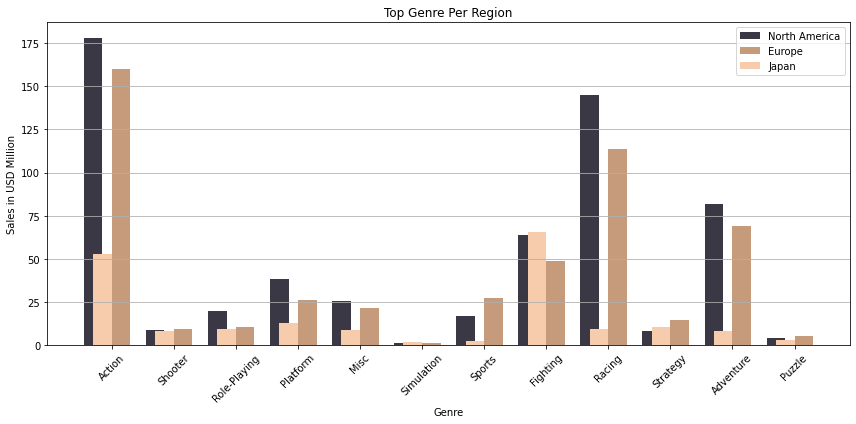

In [63]:
labels = data_filtered['genre'].unique()
na_genre = data_filtered.groupby('genre')['na_sales'].sum()
eu_genre = data_filtered.groupby('genre')['eu_sales'].sum()
jp_genre = data_filtered.groupby('genre')['jp_sales'].sum()

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(12,6))
g1 = ax.bar(x - width, na_genre, width, color='#3A3845', label='North America')
g2 = ax.bar(x + width/2, eu_genre, width, color='#C69B7B', label='Europe')
g3 = ax.bar(x - width/2, jp_genre, width, color='#F7CCAC', label='Japan')

plt.title('Top Genre Per Region')
plt.xlabel('Genre')
plt.ylabel('Sales in USD Million')
plt.xticks(rotation=45)
plt.grid(axis='y')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show();

Users in North America and Europe have similar preferences on genre, they like action, racing and adventure. Users in Japan prefer fighting genre, followed by action. Users from all regions don't really like simulation or puzzle. It may be because of shared culture and environment between North Americans and Europeans, while the Japanese have their own culture that impacts their preference in video games.

#### ESRB Ratings

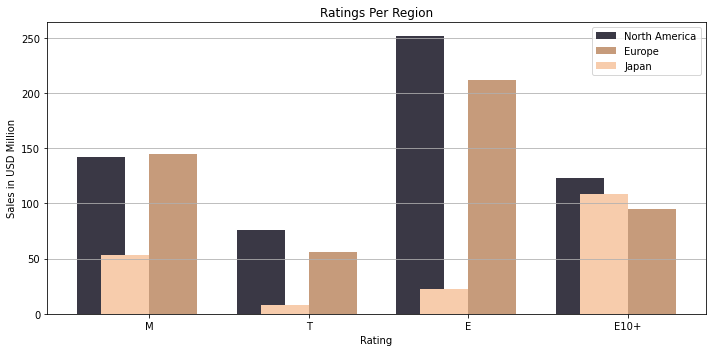

In [64]:
labels = data_filtered['rating'].unique()
na_rating = data_filtered.groupby('rating')['na_sales'].sum()
eu_rating = data_filtered.groupby('rating')['eu_sales'].sum()
jp_rating = data_filtered.groupby('rating')['jp_sales'].sum()

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, na_rating, width, color='#3A3845', label='North America')
rects2 = ax.bar(x + width/2, eu_rating, width, color='#C69B7B', label='Europe')
rects3 = ax.bar(x - width/2, jp_rating, width, color='#F7CCAC', label='Japan')

plt.title('Ratings Per Region')
plt.ylabel('Sales in USD Million')
plt.xlabel('Rating')
plt.grid(axis='y')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show();

ESRB (Entertainment Software Rating Board) rating is divided into `E: everyone; E10+: everyone 10+; T: Teen; M: Mature 17+; A: Adults only 18+; RP: rating pending.` 
Users in North America and Europe have similar preferences again, mostly playing games with E rating, while users in Japan mostly play games with E10+ rating. The T rating is the lowest in all regions. In Japan, younger children are encouraged to play outside in nature and with friends rather than playing video games at home, that's probably why only children aged 10 and above play most of the video games.

### Profile of Users in Each Region

<b>North America:</b> the users are people of all age, playing action games in X360. 

<b>Europe:</b> the users are people of all age, playing action games in PS4.

<b>Japan:</b> the users are people older than 10 years old, playing fighting games in 3DS.

## Hypotheses Testing

### User Ratings of the Xbox One and PC 

1. Null and Alternative Hypotheses

H0: The means of two statistical populations are equal. In this case it means that the average user score of XOne and PC platforms are the same.

H1: The means of two statistical populations are not equal. In this case it means that the average user score of XOne and PC platforms are different.

2. Criteria for a decision (alpha value)

In behavioral science, the level of significance is typically set at 5% and we will choose this criteria as well. When the probability of obtaining a sample mean is less than 5% if the null hypothesis were true, then we reject the value stated in the null hypothesis.

3. Calculate the t-test

In order to test our hypothesis that the means of two statistical populations are equal based on samples taken from them, we will apply the method scipy.stats.ttest_ind().

The method takes the following parameters:

- array1, array2 are arrays containing the samples. We will use the total_sales variables that we will calculate for both platforms;
- equal_var is an optional parameter that specifies whether or not the variances of the populations should be considered equal.

In [65]:
# slice the dataset for XOne and PC
xone = data_filtered.query('platform == "XOne"')
pc = data_filtered.query('platform == "PC"')

In [66]:
# check whether the missing values is high
print(xone.isnull().sum() / len(xone) * 100)
print()
print(pc.isnull().sum() / len(pc) * 100)

index              0.000000
name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       2.024291
user_score         2.024291
rating             0.000000
total_sales        0.000000
dtype: float64

index              0.000000
name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.796813
user_score         0.796813
rating             0.000000
total_sales        0.000000
dtype: float64


Since the percentage is not so big, we can drop the missing values without skewing the dataset too much.

In [67]:
xone = xone.dropna(subset=['user_score'], axis=0)
pc = pc.dropna(subset=['user_score'], axis=0)

In [68]:
print('XOne User Rating Description')
print(xone['user_score'].describe())
print()
print('PC User Rating Description')
print(pc['user_score'].describe())

XOne User Rating Description
count    242.000000
mean       6.688223
std        1.154136
min        2.100000
25%        6.200000
50%        6.850000
75%        7.387500
max        9.200000
Name: user_score, dtype: float64

PC User Rating Description
count    249.000000
mean       6.597590
std        1.494787
min        1.400000
25%        5.900000
50%        7.000000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64


Based on the description above, the variance of these two plans look similar, so we will use Levene's test to see if they actually have equal variance.

In [69]:
st.levene(xone['user_score'], pc['user_score'])

LeveneResult(statistic=9.852358679783203, pvalue=0.0017986324524250626)

The p-value suggests that the populations have equal variance. Then since equal_var is True by default, we won't set it.

In [70]:
alpha = 0.05

results = st.ttest_ind(xone['user_score'], pc['user_score'])

print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypotheses. XOne and PC's Average User Ratings are different.")
else:
    print("We retain the null hypotheses. XOne and PC's Average User Ratings are the same.")

p-value: 0.4532989815280314
We retain the null hypotheses. XOne and PC's Average User Ratings are the same.


based on the p-value result, most users of XOne and PC give similar rating to games available in these two platforms.

### User Ratings of Action and Sports Genre

1. Null and Alternative Hypotheses

H0: The means of two statistical populations are equal. In this case it means that the average user score of Action and Sports genre are the same.

H1: The means of two statistical populations are not equal. In this case it means that the average user score of Action and Sports genre are different.

2. Criteria for a decision (alpha value)

In behavioral science, the level of significance is typically set at 5% and we will choose this criteria as well. When the probability of obtaining a sample mean is less than 5% if the null hypothesis were true, then we reject the value stated in the null hypothesis.

3. Calculate the t-test

In order to test our hypothesis that the means of two statistical populations are equal based on samples taken from them, we will apply the method scipy.stats.ttest_ind().

The method takes the following parameters:

- array1, array2 are arrays containing the samples. We will use the total_sales variables that we will calculate for both platforms;
- equal_var is an optional parameter that specifies whether or not the variances of the populations should be considered equal.

In [71]:
# slice the dataset for Action and Sports genre
action = data_filtered.query('genre == "Action"')
sports = data_filtered.query('genre == "Sports"')

In [72]:
# check whether the missing values is high
print(action.isnull().sum() / len(action) * 100)
print()
print(sports.isnull().sum() / len(sports) * 100)

index              0.000000
name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.774443
user_score         0.774443
rating             0.000000
total_sales        0.000000
dtype: float64

index              0.000000
name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       3.717472
user_score         3.717472
rating             0.000000
total_sales        0.000000
dtype: float64


The missing values are very low compared to overall length of the dataset, so we can drop them before the analysis.

In [73]:
action = action.dropna(subset=['user_score'], axis=0)
sports = sports.dropna(subset=['user_score'], axis=0)

In [74]:
print('Action User Rating Description')
print(action['user_score'].describe())
print()
print('Sports User Rating Description')
print(sports['user_score'].describe())

Action User Rating Description
count    1025.000000
mean        6.945146
std         0.930798
min         2.000000
25%         6.700000
50%         7.000000
75%         7.350000
max         9.100000
Name: user_score, dtype: float64

Sports User Rating Description
count    259.000000
mean       6.382625
std        1.297563
min        1.500000
25%        5.775000
50%        6.700000
75%        7.275000
max        8.950000
Name: user_score, dtype: float64


Based on the description above, the variance of these two plans look quite different, so we will use Levene's test to see if they actually do not have equal variance.

In [75]:
st.levene(action['user_score'], sports['user_score'])

LeveneResult(statistic=43.98185433916522, pvalue=4.8733058988597093e-11)

The p-value suggests that the populations do not have equal variance. Therefore we will set equal_var to False.

In [76]:
alpha = 0.05

results = st.ttest_ind(action['user_score'], sports['user_score'], equal_var=False)

print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypotheses. Action and Sports' Average User Ratings are different.")
else:
    print("We retain the null hypotheses. Action and Sports' Average User Ratings are the same.")

p-value: 2.0566443494801325e-10
We reject the null hypotheses. Action and Sports' Average User Ratings are different.


based on the p-value result, the users give different ratings to action and sports games, despite each genre's similar popularity.

## Conclusions

1. In this report, we have analysed the games from the year 1980 to 2016. Through this report we managed to get a closer look on each users' behaviour through their game purchase, to predict which game will more likely to succeed and plan advertising campaigns.
2. Before going into the analysis, we have prepared the data by checking for any problems, changing the data types, categorising the data and adding relevant information into the dataset.
3. We have performed exploratory data analysis by looking into the games' sales and how it relates to various characteristics such as the platforms, ratings and reviews:
- Most games in this data set were released around 2007-2012, which coincides with the rise of advance technological development.
- There are a few platforms that stand out in terms of total sales: PS2, X360, PS3, Wii, DS,and PS.
- On average it takes around 10 years for new platforms to appear, peak and phase out, so we use the data from 2012 to to make sure the behaviour is still relevant in 2017.
- There are no significant differences in sales for the top platforms, or how the same games perform in different platforms.
- There is an inverse correlation between game sales and user reviews, and positive correlation between game sales and critic review.
- Action games are the most profitable and popular genre across all genre. 
- Most users in North America and Europe don't belong to specific age group as most games they choose are of E rating, while those in Japan are mostly more than 10 years old.
4. We have also tested two hypotheses, of which we have found that 

> most users of XOne and PC give similar review to games available in these two platforms

> the users give different reviews to action and sports games

Based on the conclusions above, we have the following suggestions for Ice:
- Users in North America and Europe have quite similar behaviour,
- Action games are most likely to succeed in North America and Europe, regardless of the platform. 
- PS4 and XOne are on the rise and they have phased out their predecessors.